# **FUNCTIONING ETL**

* Libraries to import

In [1]:
# for files
import os
import zipfile
import requests
from io import BytesIO
import time

# for data
import re
import numpy as np
import pandas as pd
import geopandas as gpd

# for viz
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [2]:
import sys

print(sys.path.append('../'))

None


___________________

### **1**
### GLOBAL VARIABLES 

In [3]:
from nyc_taxi_etl import m_globals as GL

* **1.1** DATA SOURCES

In [4]:
#data sources from test repo

NYC_TAXI_ZIP = GL.NYC_TAXI_ZIP; print(f"{NYC_TAXI_ZIP}\n")
NYC_ACS = GL.NYC_ACS; print(f"{NYC_ACS}\n")
NYC_BLOCK_GEOM = GL.NYC_BLOCK_GEOM; print(f"{NYC_BLOCK_GEOM}\n")

https://storage.googleapis.com/hiring-test/data.zip

https://storage.googleapis.com/hiring-test/nyc_acs_demographics.csv

https://storage.googleapis.com/hiring-test/nyc_cbg_geoms.geojson



* **1.2** DATA DICTIONARIES

Explanation of some cols as indicated in NYC_TAXI_DICT

In [5]:
# dictionaries necessary for data transformation

VENDORID_DICT = GL.VENDORID_DICT; print(f"{VENDORID_DICT}\n")
RATECODEID_DICT = GL.RATECODEID_DICT; print(f"{RATECODEID_DICT}\n")
PAYMENTTYPE_DICT = GL.PAYMENTTYPE_DICT; print(f"{PAYMENTTYPE_DICT}\n")

{1: 'Creative_Mobile_Technologies', 2: 'VeriFone_INC'}

{1: 'Standard_Rate', 2: 'JFK', 3: 'Newark_Westchester', 4: 'Nassau', 5: 'Negotiated', 6: 'Group_Ride', 99: 'UNKNOWN'}

{1: 'Credit_Card', 2: 'Cash', 3: 'No_Charge', 4: 'Dispute', 5: 'Unknown', 6: 'Voided_Trip'}



__________

### **2**
### ETL

from folder with pipeline

In [6]:
from nyc_taxi_etl.m_opening import request_info_from_ZIP
from nyc_taxi_etl.m_opening import getting_df_fromZip

from nyc_taxi_etl.m_data_transformation import datetime_transformations
from nyc_taxi_etl.m_data_transformation import coord_to_geomObject
from nyc_taxi_etl.m_data_transformation import abs_var_col
from nyc_taxi_etl.m_data_transformation import total_amount_inconsistency

from nyc_taxi_etl.m_wrangling import data_etl

* **2.1** LET'S GET DATA

In [9]:
info_from_zip = request_info_from_ZIP(zipfile_dir = NYC_TAXI_ZIP)

---------------------- Getting ZIP file
---------------------- Done in 3.0'59.885''


* **2.2** LET'S GET FRAMES AND CLEANING THEM.

In a normal situation, the cleaning def shoul run while loading the data from the request response, but my computer dies or de kernel restarts due to memory failures because of my current setup.
To avoid drama this is splitted in to phases:

In [10]:
frames = getting_df_fromZip( zipfile_info = info_from_zip,
                             minLen_toDisgard = 7,
                             first_row = 5,
                             num_rows = 35
                           )

---------------------- Opening ZIP file and construction of DF 

data/yellow_tripdata_2015-07_00 	Done 	 Memory Usage: 2.12 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_00 	Done 	 Memory Usage: 4.24 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_01 	Done 	 Memory Usage: 6.36 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_02 	Done 	 Memory Usage: 8.48 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_03 	Done 	 Memory Usage: 10.6 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_04 	Done 	 Memory Usage: 12.72 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_05 	Done 	 Memory Usage: 14.84 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_06 	Done 	 Memory Usage: 16.97 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_07 	Done 	 Memory Usage: 19.09 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_08 	Done 	 Memory Usage: 21.21 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-01_09 	Done 	 Memory Usage: 23.33 Mb 	 Shape (14286, 19)
data/yellow_tripdata_2015-0

In [11]:
for i, frame in enumerate(frames[::2]):
    print(f"\n\n{i} Frame ---------------------------------------------")
    tic = time.perf_counter()
    data_etl( df_to_transform  = frame,
              dict_ratecodeID  = RATECODEID_DICT,
              dict_paymenttype = PAYMENTTYPE_DICT,
              drop_cols = True
              )

    toc = time.perf_counter()
    mins = (toc - tic) // 60; secs = np.around((toc - tic) % 60, 3)
    print(f" Frame cleaned in  transformed in {mins}'{secs}''")



0 Frame ---------------------------------------------
---------------------- Transform OBJECT to DATETIME
tpep_pickup_datetime transformed in 0.0'0.156''
tpep_dropoff_datetime transformed in 0.0'0.147''
Latitude cols found:	 ['dropoff_latitude', 'pickup_latitude']
Longitude cols found:	 ['dropoff_longitude', 'pickup_longitude']

Adding new col:	 dropoff_geometry	Done
Adding new col:	 pickup_geometry	Done

Dropping cols ['dropoff_latitude', 'pickup_latitude', 'dropoff_longitude', 'pickup_longitude']		TRUE

---------------------- Transform NEG PRICES to POSITIVE PRICES
 Objects transformed in 0.0'0.001''
 Frame cleaned in  transformed in 0.0'0.491''


1 Frame ---------------------------------------------
---------------------- Transform OBJECT to DATETIME
tpep_pickup_datetime transformed in 0.0'0.151''
tpep_dropoff_datetime transformed in 0.0'0.141''
Latitude cols found:	 ['dropoff_latitude', 'pickup_latitude']
Longitude cols found:	 ['dropoff_longitude', 'pickup_longitude']

Adding ne

In [12]:
df_all = pd.concat(frames[::2]); display(df_all.shape)

(537490, 14)

The final DF to work with has pretty much the same row lenght as one month's data. Picking every nth rows and one every two frames is a way to avoid increase bias in data, so the model is still balanced. This is tacking into consideration that every file is a day of data and all data is ordered by pickup_datetime.

In [13]:
df_all.head()

,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,pickup_datetime,dropoff_datetime,dropoff_geometry,pickup_geometry
5,2,1.00,Standard_Rate,Cash,6.5,0.5,0.5,0.00,0.0,0.3,2015-07-01 00:00:00,2015-07-01 00:06:46,POINT (-73.96935 40.76925),POINT (-73.95916 40.77343)
40,1,1.92,Standard_Rate,Credit_Card,9.0,0.5,0.5,15.00,0.0,0.3,2015-07-01 00:00:09,2015-07-01 00:10:31,POINT (-73.98246 40.77155),POINT (-73.97074 40.75326)
75,2,5.47,Standard_Rate,Cash,18.5,0.5,0.5,0.00,0.0,0.3,2015-07-01 00:00:15,2015-07-01 00:16:14,POINT (-74.01466 40.71670),POINT (-73.98355 40.73895)
110,1,9.80,UNKNOWN,Credit_Card,36.0,0.5,0.5,7.46,0.0,0.3,2015-07-01 00:00:22,2015-07-01 00:45:18,POINT (-73.96234 40.76064),POINT (-73.96568 40.71048)
145,2,2.88,Standard_Rate,Cash,12.0,0.5,0.5,0.00,0.0,0.3,2015-07-01 00:00:30,2015-07-01 00:13:41,POINT (-73.98151 40.76142),POINT (-74.00053 40.73008)


__________

### **3**
### DATA EXPLORATION

In [21]:
df_columns = [col for col in df_all.columns if not re.findall('geometry', col)]

['passenger_count',
 'trip_distance',
 'RatecodeID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'pickup_datetime',
 'dropoff_datetime']

In [14]:
df_columns = [col for col in df_all.columns if not re.findall('geometry', col)]

nyc_pìckups = gpd.GeoDataFrame(df_all[df_columns], geometry = df_all['pickup_geometry']); display(nyc_pìckups.head(1))
nyc_dropoffs = gpd.GeoDataFrame(df_all[df_columns], geometry = df_all['dropoff_geometry']); display(nyc_dropoffs.head(1))

,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,pickup_datetime,dropoff_datetime,geometry
5,2,1.0,Standard_Rate,Cash,6.5,0.5,0.5,0.0,0.0,0.3,2015-07-01,2015-07-01 00:06:46,POINT (-73.95916 40.77343)


,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,pickup_datetime,dropoff_datetime,geometry
5,2,1.0,Standard_Rate,Cash,6.5,0.5,0.5,0.0,0.0,0.3,2015-07-01,2015-07-01 00:06:46,POINT (-73.96935 40.76925)


IN order to be able to merge both GDFs with the census block geometry, they both have to have the same projection.
Is this case, both datasets above dont have any geometry (they are naive), so let's see how everything plays if we set it to the same projection as the census GeoJson.

In [16]:
census_geom = gpd.read_file(NYC_BLOCK_GEOM); census_geom.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

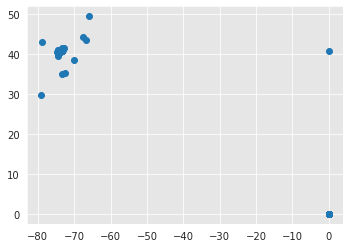

In [18]:
nyc_pìckups.set_crs(epsg = 4326).plot()

<AxesSubplot:>

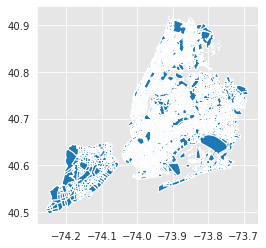

In [17]:
census_geom.plot()